# Image classification

The objectif is to build a ML algorithm to classify the cats and dogs pictures.

We'll follow these steps:

1.   Explore the Example Data of Cats and Dogs.
2.   Build and Train a Neural Network to recognize the difference between the two.
3.   Evaluate the Training and Validation accuracy.

## Explore the Example Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Let's unzip the data**

In [3]:
import os
import zipfile

local_zip = './train.zip'




zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
import os
import zipfile

local_zip = './test1.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

Now, let's see what the filenames look like in the cats and dogs train and test directories 

In [5]:
base_directory = '/tmp'

dir_train=os.path.join(base_directory, 'train')
train_fnames=os.listdir(os.path.join(dir_train))
train_fnames[:10]

['cat.0.jpg',
 'cat.1.jpg',
 'cat.10.jpg',
 'cat.100.jpg',
 'cat.1000.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg']

In [6]:
dir_test1=os.path.join('/tmp', 'test1')
test_fnames=os.listdir(os.path.join(dir_test1))
test_fnames[:10]

['1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '10000.jpg',
 '10001.jpg',
 '10002.jpg',
 '10003.jpg',
 '10004.jpg',
 '10005.jpg']

In [7]:
print('total training cat images :', len(os.listdir(      dir_train ) ))

print('total validation cat images :', len(os.listdir( dir_test1 ) ))

total training cat images : 25000
total validation cat images : 12500


Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like.

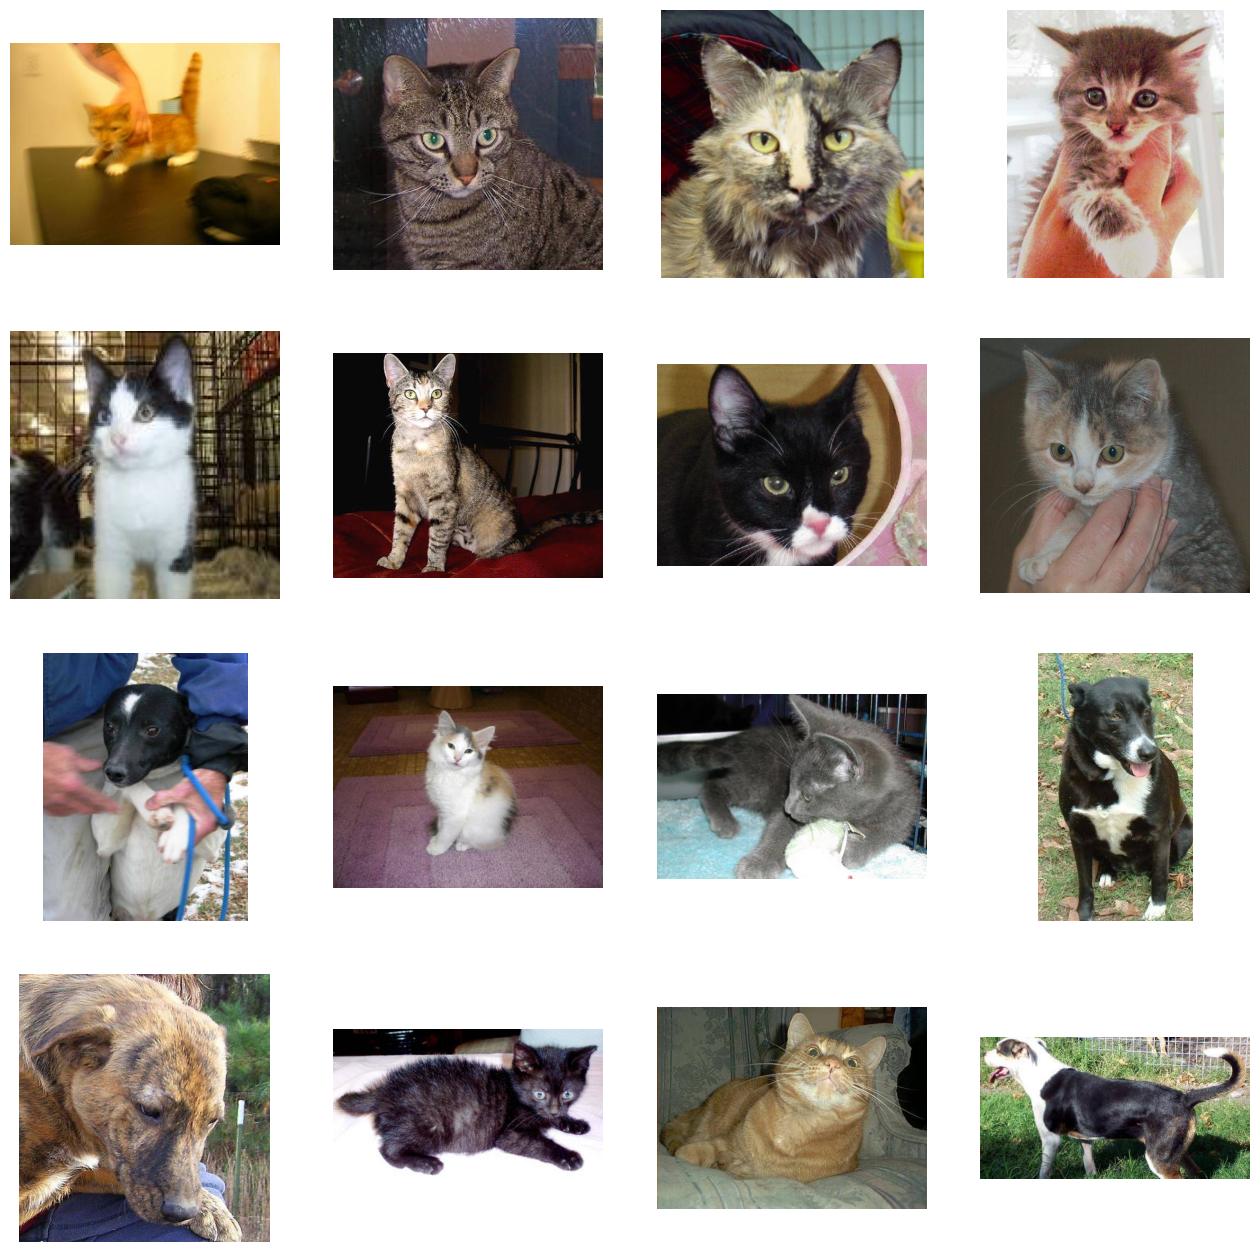

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_train_pix = [os.path.join(dir_train, fname) 
                for fname in train_fnames[ pic_index-8:pic_index] 
               ]

next_test_pix = [os.path.join(dir_test1, fname) 
                for fname in test_fnames[ pic_index-8:pic_index] 
               ]

for i, img_path in enumerate(next_train_pix+next_test_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a model

Step 1 will be to import tensorflow.

In [9]:
import tensorflow as tf


We define a class "myCallback" that stops training to avoid overfitting.

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [11]:
callbacks = myCallback()

In [12]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(712, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

The model.summary() method call prints a summary of the NN

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 32)        0

In [14]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Pre-processing


In [15]:
fnames=train_fnames
categories=[]
for filenm in fnames:
    label=filenm.split('.')[0]
    if label=='dog':
        categories.append(1)
    else:
        categories.append(0)
        
train=pd.DataFrame({'fnames':fnames,'category':categories}) 
train[0:10]

,fnames,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
5,cat.10000.jpg,0
6,cat.10001.jpg,0
7,cat.10002.jpg,0
8,cat.10003.jpg,0
9,cat.10004.jpg,0


In [16]:
from sklearn.model_selection import train_test_split
train_df,validate_df=train_test_split(train,test_size=0.2,random_state=0)
train_df=train_df.reset_index(drop=True)
test_df=validate_df.reset_index(drop=True)

In [17]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    '/tmp/train',
                                                    x_col = 'fnames',
                                                    y_col='category',
                                                    batch_size=20, 
                                                    class_mode='raw', 
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_dataframe(validate_df,
                                                   '/tmp/train',
                                                   x_col = 'fnames',
                                                   y_col='category',
                                                   batch_size=20,
                                                   class_mode  = 'raw',
                                                   target_size = (150, 150))

Found 20000 validated image filenames.
Found 5000 validated image filenames.


###  

In [18]:
history = model.fit(train_generator,
                              validation_data=test_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_steps=50,
                              verbose=2,
                              callbacks=[callbacks])

Epoch 1/100
100/100 - 45s - loss: 0.7047 - accuracy: 0.5095 - val_loss: 0.6925 - val_accuracy: 0.4970 - 45s/epoch - 451ms/step
Epoch 2/100
100/100 - 35s - loss: 0.6873 - accuracy: 0.5505 - val_loss: 0.6823 - val_accuracy: 0.5970 - 35s/epoch - 347ms/step
Epoch 3/100
100/100 - 34s - loss: 0.6826 - accuracy: 0.5735 - val_loss: 0.6609 - val_accuracy: 0.5910 - 34s/epoch - 339ms/step
Epoch 4/100
100/100 - 30s - loss: 0.6472 - accuracy: 0.6150 - val_loss: 0.6042 - val_accuracy: 0.6730 - 30s/epoch - 302ms/step
Epoch 5/100
100/100 - 38s - loss: 0.6172 - accuracy: 0.6585 - val_loss: 0.6238 - val_accuracy: 0.6470 - 38s/epoch - 381ms/step
Epoch 6/100
100/100 - 26s - loss: 0.6084 - accuracy: 0.6700 - val_loss: 0.6301 - val_accuracy: 0.6420 - 26s/epoch - 263ms/step
Epoch 7/100
100/100 - 24s - loss: 0.5910 - accuracy: 0.6845 - val_loss: 0.5886 - val_accuracy: 0.6810 - 24s/epoch - 241ms/step
Epoch 8/100
100/100 - 24s - loss: 0.5811 - accuracy: 0.6985 - val_loss: 0.5701 - val_accuracy: 0.6850 - 24s/epo

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
train_img_files = [os.path.join(dir_train, f) for f in train_fnames]

img_path = random.choice(train_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )